In [ ]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# Solver Introduction
This tutorial shows the complete solution of a combinatorial optimization problem:
1. First a model is designed and implemented as polynomial. 
2. Then the polynomial is sent as QUBO to a solving platform. 
3. In the last step the result is interpreted and displayed as solution of the original problem. 

The problem handled here is the N-Queens puzzle. It is the challenge to place 8 queens on a chessboard without any queen threatening any other queen. In a generalization of the puzzle N queens are placed on an NxN chessboard. Some ideas for modeling the problem can be found in the document [N-Queens introduction](I_02_Solver_introduction.pdf). For more information about this problem please visit [here](https://en.wikipedia.org/wiki/Eight_queens_puzzle).

### Preparation

We import the necessary libraries for Digital Annealer access .

In [1]:
from dadk.QUBOSolverCPU import *
from dadk.BinPol import *

### Exercise 1: Index Function
In our model we want to use bits with 2-dimensional index for row and column on the NxN chessboard. Write a function `index_x` that translates the zero based two dimensional index $(row,column)$ to a linear index. It takes row and column the number of side length of the board as arguments. To make things easy take all indices zero based. 

In [2]:
def index_x(row,column,N):
    #start coding here
    return row*N + column

The following function `printSolution` will be used later. Here you can execute the following block to test your index function.

In [3]:
def printSolution(solution,N):
    print("\n%d queens on %dx%d chessboard:" % (N,N,N))
    for r in range(N):
        for c in range(N):
            if solution[index_x(r,c,N)]:
                print('Q', end='')
            else:
                print('.', end='')
        print()
# test functions
printSolution([0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0],4)


4 queens on 4x4 chessboard:
.Q..
...Q
Q...
..Q.


### Exercise 2: QUBO for a row
To ensure, that exactly 1 queen is positioned in each row, we use the following energy function as part of our QUBO

$$
H_{row}=\sum_{r=0}^{N-1}(1-\sum_{c=0}^{N-1}x_{r,c})^2
$$

Please write a function `H_row`, that returns a binary polynomial of the upper form.

In [4]:
def H_row(N):
    #start coding here
    H = BinPol()
    for r in range(N):
        p = BinPol()
        p.add_term(1,())
        for c in range(N):
            p.add_term(-1,(index_x(r,c,N),))
        p.multiply(p)
        H.add(p)
    return H

print(H_row(4))

4 - x_0 + 2 x_0 x_1 + 2 x_0 x_2 + 2 x_0 x_3 - x_1 + 2 x_1 x_2 + 2 x_1 x_3 - x_2 + 2 x_2 x_3 - x_3 - x_4 + 2 x_4 x_5 + 2 x_4 x_6 + 2 x_4 x_7 - x_5 + 2 x_5 x_6 + 2 x_5 x_7 - x_6 + 2 x_6 x_7 - x_7 - x_8 + 2 x_8 x_9 + 2 x_8 x_10 + 2 x_8 x_11 - x_9 + 2 x_9 x_10 + 2 x_9 x_11 - x_10 + 2 x_10 x_11 - x_11 - x_12 + 2 x_12 x_13 + 2 x_12 x_14 + 2 x_12 x_15 - x_13 + 2 x_13 x_14 + 2 x_13 x_15 - x_14 + 2 x_14 x_15 - x_15


### Exercise 3: Similar QUBO for column
Next realize the energy function for one queen per column:
$$
H_{column}=\sum_{c=0}^{N-1}(1-\sum_{r=0}^{N-1}x_{r,c})^2
$$

In [5]:
def H_column(N):
    #start coding here
    H = BinPol()
    for c in range(N):
        p = BinPol()
        p.add_term(1,())
        for r in range(N):
            p.add_term(-1,(index_x(r,c,N),))
        p.multiply(p)
        H.add(p)
    return H

### Exercise 4: QUBO for diagonal
Finally realize an energy function that delivers penalties for more than one queen per diagonal line. 

Hint: The coordinates $(r,c)$ and $(r´,c´)$ are on the same diagonal iff $r-c=r´-c´$ or $r+c=r´+c´$. Let $f:\{0,1,2 ,..N-1\}^4 \to \{0,1\}$ be a function with $f(a,b,c,d)=1$ if $a-b=c-d$ or $a+b=c+d$ for different pairs $(a,b) \ne (c,d)$ and $f(a,b,c,d)=0$ in all other cases. Using this we can write the polynomial $H_{diagonal}$:
$$
H_{diagonal}=\sum_{(r,c) diagonal to (r´,c´)} x_{r,c}x_{r´,c´}= 
  \sum_{r=0}^{N-1}\sum_{c=0}^{N-1}\sum_{r´=0}^{N-1}\sum_{c´=0}^{N-1}f(r,c,r´,c´)x_{r,c}x_{r´,c´}
$$
Use the last representation to implement a QUBO `H_diagonal(N)`.

In [6]:
def H_diagonal(N):
    #start coding here
    H = BinPol()
    for r in range(N):
        for c in range(N):
            for rs in range(N):
                for cs in range(N):
                    if (( r-c == rs-cs or r+c == rs+cs ) and
                        ( r!=rs or c!=cs ) ):
                        H.add_term(1,(index_x(r,c,N),index_x(rs,cs,N)))
    return H

### Exercise 5: An N-queens QUBO
Now the complete QUBO can be implemented as sum of the QUBOs for row, column and diagonal:
$$
H_{all} = A ( H_{row} + H_{column} + H_{diagonal} )
$$
Since all QUBOs for row, column and diagonal have coefficients in the same range of 1 or 2 and start with penalty 1 for a single deviation from constraints we use a common factor for all sums.

In [7]:
def H_all(N,A=1):
    #start coding here
    H = BinPol()
    H.add(H_row(N))
    H.add(H_column(N))
    H.add(H_diagonal(N))
    H.multiply_scalar(A)
    return H
print(H_all(4,10000))

80000 - 20000 x_0 + 20000 x_0 x_1 + 20000 x_0 x_2 + 20000 x_0 x_3 + 20000 x_0 x_4 + 20000 x_0 x_5 + 20000 x_0 x_8 + 20000 x_0 x_10 + 20000 x_0 x_12 + 20000 x_0 x_15 - 20000 x_1 + 20000 x_1 x_2 + 20000 x_1 x_3 + 20000 x_1 x_4 + 20000 x_1 x_5 + 20000 x_1 x_6 + 20000 x_1 x_9 + 20000 x_1 x_11 + 20000 x_1 x_13 - 20000 x_2 + 20000 x_2 x_3 + 20000 x_2 x_5 + 20000 x_2 x_6 + 20000 x_2 x_7 + 20000 x_2 x_8 + 20000 x_2 x_10 + 20000 x_2 x_14 - 20000 x_3 + 20000 x_3 x_6 + 20000 x_3 x_7 + 20000 x_3 x_9 + 20000 x_3 x_11 + 20000 x_3 x_12 + 20000 x_3 x_15 - 20000 x_4 + 20000 x_4 x_5 + 20000 x_4 x_6 + 20000 x_4 x_7 + 20000 x_4 x_8 + 20000 x_4 x_9 + 20000 x_4 x_12 + 20000 x_4 x_14 - 20000 x_5 + 20000 x_5 x_6 + 20000 x_5 x_7 + 20000 x_5 x_8 + 20000 x_5 x_9 + 20000 x_5 x_10 + 20000 x_5 x_13 + 20000 x_5 x_15 - 20000 x_6 + 20000 x_6 x_7 + 20000 x_6 x_9 + 20000 x_6 x_10 + 20000 x_6 x_11 + 20000 x_6 x_12 + 20000 x_6 x_14 - 20000 x_7 + 20000 x_7 x_10 + 20000 x_7 x_11 + 20000 x_7 x_13 + 20000 x_7 x_15 - 20000 x_8

Next we implement the QUBO along the formula shown above.

### Exercise 6: Annealing
The solver is instantiated with many parameters, which control the annealing process (see below).

As processor you can set `CPU`. Use the parameter `graphics=True` for later visualization. 

In [8]:
solver = QUBOSolverCPU(
    number_iterations=1000,      # Total number of iterations per run.
    number_runs=16,              # Number of stochastically independent runs.
    temperature_start=5000,      # Start temperature of the annealing process.
    temperature_end=10,          # End temperature of the annealing process.
    temperature_mode=0,          # 0, 1, or 2 to define the cooling curve:
                                 #    0, 'EXPONENTIAL':
                                 #       reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                 #    1, 'INVERSE':
                                 #       reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                 #    2, 'INVERSE_ROOT':
                                 #       reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
    temperature_interval=1,      # Number of iterations keeping temperature constant.
    offset_increase_rate=5000.0, # Increase of dynamic offset when no bit selected. Set to 0.0 to switch off dynamic energy feature.
    graphics=True                # create data for graphics output
)

Create a polynomial H using the function `H_all`.

Call the `minimize` method of `solver` to start the annealing process. `minimize` returns an object of class `SolutionList` with the results. The method `get_minimum_energy_solution` gets from the solution list an object of class `Solution` with the lowest energy found.

Print the attribute `configuration` of the `Solution` object. You can use this dictionary directly or you can convert it to a list with the help of its `values` method.

Compute the value of the polynomial at the solution point and make sure that the energy is zero.

User the function `printSolution` to display the result as chessboard.

In [9]:
N=4
A=10000
H = H_all(N,A)

print(H.N)

#start coding here

solution_list = solver.minimize(H) 
    
configuration = solution_list.min_solution.configuration

print(configuration)

print("H = %10.6f" % H.compute(configuration))

printSolution(configuration, N)


16
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
H =   0.000000

4 queens on 4x4 chessboard:
..Q.
Q...
...Q
.Q..


### Exercise 7: Visualization
The `SolutionList` object has a method `print_stats` to display information about the recent annealing process. If you have constructed the `QUBOSolverCPU` object with the parameter `graphics=True`, then you can visualize the last annealing process. This is done by the method `display_graphs` of the returned `SolutionList` object. Visualization only works for `CPU`.

Look at the graphics. Change parameters of the solver (temperatures, energy, interval , etc. and see the consequences to the result and the visualized process in the graphics. More information about the visualization and the annealing can be found in [Optimizer UI functions](../Optimizer_I/O_02_Optimizer_UI_functions.ipynb) and in the [Annealing](../Development_KIT_Miscellaneous/M_01_Annealing/M_01_Annealing.ipynb) tutorial.

Input parameters
  Total number of iterations per run________: 1000
  number_runs_______________________________: 16
  Number of replicas________________________: 26
  Temperature mode__________________________: 0
  Temperature mode text_____________________: EXPONENTIAL
  Start temperature_________________________: 5000.0
  Final temperature (mode 3)________________: 10.0
  Temperature decay (mode 0)________________: 0.0095
  Temperature interval (mode 0)_____________: 1
  Dynamic energy offset_____________________: 5000.0
  Solution mode_____________________________: COMPLETE
  Optimization method_______________________: annealing
  Annealer version__________________________: 2
  Bit precision_____________________________: 16
  Processor_________________________________: CPU
  graphics.value____________________________: 1
  graphics.name_____________________________: SINGLE
Runtime
  Execution technology______________________: CPU
  Job identification________________________: ('Marku

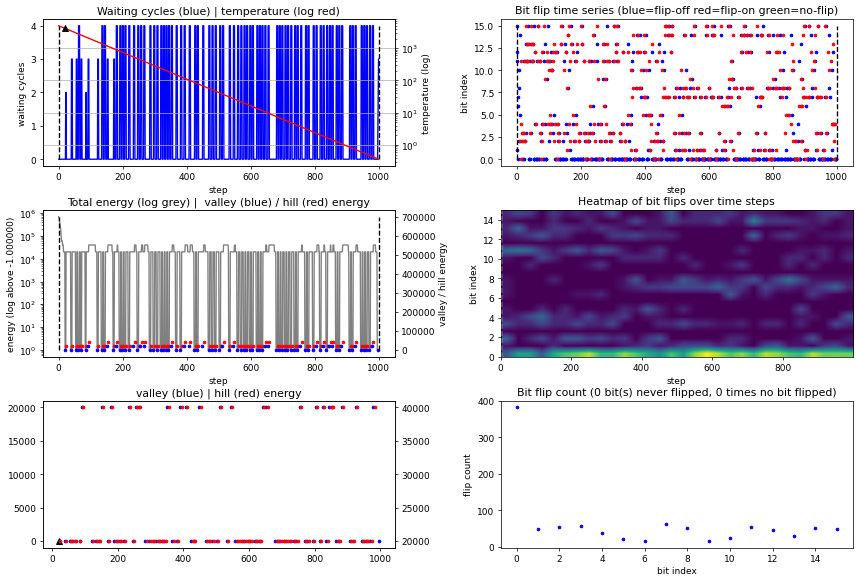

In [10]:
solution_list.print_stats()
solution_list.display_graphs()